In [1]:
from scipy.io import wavfile
import numpy as np
from statistics import mean

import matplotlib
import matplotlib.pyplot as plt

import sklearn.model_selection as models
import sklearn.neighbors as skkn
import sklearn.linear_model as sklm
import sklearn.gaussian_process as skgp

import librosa
import librosa.display

import soundfile
import IPython.display as ipd

import time

In [2]:
#sim_samplerate, sim_data = wavfile.read(filename="samples/sim/sim_music_01.wav", mmap=False)
#act_samplerate, act_data = wavfile.read(filename="samples/actual/act_music_01.wav", mmap=False)

data_sr = 20000

music_sim_data, m_sim_sr = librosa.load('samples/sim/sim_music_01.wav', sr=data_sr)
music_act_data, m_act_sr = librosa.load('samples/actual/act_music_01.wav', sr=data_sr)
vocal_sim_data, v_sim_sr = librosa.load('samples/sim/sim_human_voice_01.wav', sr=data_sr)
vocal_act_data, v_act_sr = librosa.load('samples/actual/act_human_voice_01.wav', sr=data_sr)

raw_length = vocal_act_data.shape[0]
length_s = raw_length/v_act_sr

print(f"Simulation samplerate: {v_sim_sr}")
print(f"Actual samplerate: {v_act_sr}")

print(f"time length: {length_s}s")
print(f"Simulation data points: {vocal_sim_data.shape[0]}")
print(f"Actual data points: {vocal_act_data.shape[0]}")

Simulation samplerate: 20000
Actual samplerate: 20000
time length: 2.55465s
Simulation data points: 51092
Actual data points: 51093


In [3]:
feature_size = 1024

# each x,y set pair is one data point. each coordinate in each pair is a feature. 

# x_dataset = np.empty((int(raw_length/feature_size)+1, feature_size))
# y_dataset = np.empty((int(raw_length/feature_size)+1, feature_size))

# dset_ndx = 0

# data_incr = np.arange(0, raw_length, feature_size, dtype=int)

# for slc_start in data_incr:
#     slc_end = slc_start+(feature_size)
    
#     #print(slc_start, slc_end)

#     if slc_end > raw_length:
#         break
        
#     x_dataset[dset_ndx] = vocal_sim_data[slc_start:slc_end]
#     y_dataset[dset_ndx] = vocal_act_data[slc_start:slc_end]

#     dset_ndx += 1
    
x_dataset = vocal_sim_data
y_dataset = vocal_act_data[0:-1]

def slice_raw_data_for_models(np_arr, feature_size):
    output = []
    for ndx in np.arange(0, np_arr.shape[0]-1, feature_size, dtype=int):
        output.append(np_arr[ndx:ndx+feature_size])
    output.pop(len(output)-1)
    return output


def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

x_dataset = slice_raw_data_for_models(vocal_sim_data, feature_size)
y_dataset = slice_raw_data_for_models(vocal_act_data[:-1], feature_size)



In [4]:
X_train, X_test, y_train, y_test = models.train_test_split(x_dataset, y_dataset, shuffle=False) # shuffled

In [63]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


AttributeError: 'list' object has no attribute 'shape'

In [13]:
# KNN model fitting, save results to wav file for human comparison
#input_data = slice_raw_data_for_models(np_arr=vocal_act_data, feature_size=feature_size)
#output_comp = slice_raw_data_for_models(np_arr=vocal_sim_data, feature_size=feature_size)

# X_train = X_train.reshape(-1,1)
# X_test = X_test.reshape(-1,1)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)

N = 2

time_start = time.time()
mdl = skkn.KNeighborsRegressor(n_neighbors=N)
mdl.fit(X_train, y_train)

# results = np.empty([0, len(vocal_act_data)])

# for dp in input_data:
#    pdict = mdl.predict([dp])
#    for ft in pdict[0]:
#        results = np.append(results, ft)

time_end = time.time()
result_time = time_end - time_start
test_predict = mdl.predict(X_test)
result = []
for dp in test_predict:
    result.append(dp[0])
    
#print(f"KNN model application complete. Elapsed: {result_time}s")
print("Train Score: {:.2f}".format(mdl.score(X_train, y_train)))
print("Test Score: {:.2f}".format(mdl.score(X_test, y_test)))

# print_plot_play(X_test, data_sr, text=f"Input data")
# print_plot_play(test_predict, data_sr, text=f"KNN Prediction, N={N}")
# print_plot_play(y_test, data_sr, text="Expected result")

# soundfile.write("test.wav", test_predict, data_sr)

Train Score: 0.73
Test Score: -0.11


ValueError: x and y must be the same size

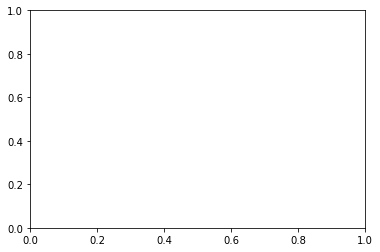

In [15]:
#fig, axes = plt.subplots(1, 3, figsize=(10, 10))
x_indexes = np.arange(0, 845)
y_indexes = np.arange(0, 845)

act_points = []
for dataset in X_train:
    res = mean(dataset)
    act_points.append(res)
    
sim_points = []
for dataset in y_train:
    res = mean(dataset)
    sim_points.append(res)
    
plt.scatter(act_points, x_indexes)
plt.scatter(sim_points, y_indexes)

In [5]:
# Linear Regression model fitting, save results to wav file for human comparison

time_start = time.time()
mdl = sklm.LinearRegression()
mdl.fit(X_train, y_train)

test_predict = mdl.predict(X_test)
result = []
for dp in test_predict:
    result.append(dp[0])
    
time_end = time.time()
result_time = time_end - time_start
print(f"Linear Regression model application complete. Elapsed: {result_time}s")
print("Train Score: {:.2f}".format(mdl.score(X_train, y_train)))
print("Test Score: {:.2f}".format(mdl.score(X_test, y_test)))

#print_plot_play(results, data_sr, text=f"Linear Regression Prediction")
#print_plot_play(sim2_data, data_sr, text="Simulation Comparison")

Linear Regression model application complete. Elapsed: 0.07355833053588867s
Train Score: 1.00
Test Score: -0.82


In [150]:
# ridge regression = failure on act2 raw
# RidgeCV regression = failure on act2 raw
# Lasso regression = failure on act2 raw
# NN radius model = failure on act2 raw


In [12]:
# Gaussian Process model fitting, save results to wav file for human comparison
time_start = time.time()
mdl = skgp.GaussianProcessRegressor(alpha=10, )
mdl.fit(X_train, y_train)

test_predict = mdl.predict(X_test)
result = []
for dp in test_predict:
    result.append(dp[0])

time_end = time.time()
result_time = time_end - time_start
print(f"Gaussian model application complete. Elapsed: {result_time}s")
print("Train Score: {:.2f}".format(mdl.score(X_train, y_train)))
print("Test Score: {:.2f}".format(mdl.score(X_test, y_test)))

# print_plot_play(results, data_sr, text=f"Gaussian Prediction, N={N}")
# print_plot_play(sim2_data, data_sr, text="Simulation Comparison")

Gaussian model application complete. Elapsed: 0.010788917541503906s
Train Score: 0.14
Test Score: -0.11
